Сравнение различных моделей рекомендательных систем на датасете movilens

Кузьмина Н.В. J4240

1. Скачать набор данных о рейтингах кинофильмов по ссылке
https://grouplens.org/datasets/movielens/latest/ (файл ml-latest-small.zip),
разделить данные случайным образом на тренировочный и тестовый наборы
данных с соотношением 7/3 с помощью языка python.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.cluster import KMeans

In [ ]:
tags = pd.read_csv('/content/drive/MyDrive/Рекомендательные системы/ml-latest-small/tags.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Рекомендательные системы/ml-latest-small/ratings.csv')
links = pd.read_csv('/content/drive/MyDrive/Рекомендательные системы/ml-latest-small/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/Рекомендательные системы/ml-latest-small/movies.csv')

In [ ]:
train_data, test_data = train_test_split(ratings, test_size=0.3, random_state=42)

In [ ]:
print(f"Размер тренировочного набора: {len(train_data)}")
print(f"Размер тестового набора: {len(test_data)}")

Размер тренировочного набора: 70585
Размер тестового набора: 30251


2. Реализовать метрики новизны и разнообразия.

Функции расчета всех метрик:



*   MAP@K



In [ ]:
def apk(actual, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual_list, predicted_list, k):
    return np.mean([apk(a, p, k) for a, p in zip(actual_list, predicted_list)])

- NDCG@K

In [ ]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.asfarray(relevance_scores)[:k]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.0

def ndcg_at_k(actual, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]
    relevance_scores = [1 if p in actual else 0 for p in predicted]
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance_scores = [1] * min(len(actual), k)
    idcg = dcg_at_k(ideal_relevance_scores, k)
    if idcg == 0.0:
        return 0.0
    return dcg / idcg

def mean_ndcg(actual_list, predicted_list, k=10):
    return np.mean([ndcg_at_k(a, p, k) for a, p in zip(actual_list, predicted_list)])

In [ ]:
k_values = [1, 5, 10, 20, 30, 40, 50]

def compute_metrics_at_k(k_values, actual_list, recommendations_list):
    map_scores = {}
    ndcg_scores = {}

    for k in k_values:
        mapk_score = mapk(actual_list, recommendations_list, k)
        mean_ndcg_score = mean_ndcg(actual_list, recommendations_list, k)

        map_scores[k] = mapk_score
        ndcg_scores[k] = mean_ndcg_score

    metrics_df = pd.DataFrame({
        'K': k_values,
        'MAP@K': [map_scores[k] for k in k_values],
        'NDCG@K': [ndcg_scores[k] for k in k_values]
    })

    return metrics_df

- Функция для расчета Новизны

In [ ]:
def calculate_novelty(recommendations, item_popularity, total_users):
    novelty_scores = []
    for recs in recommendations:
        if not recs:
            continue
        user_novelty = 0.0
        for item in recs:
            pop = item_popularity.get(item, 0)
            if pop > 0:
                user_novelty += np.log2(total_users / pop)
            else:
                user_novelty += np.log2(total_users)

        novelty_scores.append(user_novelty / len(recs))
    return np.mean(novelty_scores) if novelty_scores else 0.0

In [ ]:
item_popularity = train_data.groupby('movieId')['userId'].count().to_dict()
total_users = len(train_data['userId'].unique())
total_items = len(train_data['movieId'].unique())

 - Функция для расчета Разнообразия

In [ ]:
def calculate_diversity(recommendations, item_features):
    diversity_scores = []
    for recs in recommendations:
        pairwise_diversity = []
        for i in range(len(recs)):
            for j in range(i + 1, len(recs)):
                features_i = item_features.get(recs[i], set())
                features_j = item_features.get(recs[j], set())
                if features_i and features_j:
                    similarity = len(features_i & features_j) / len(features_i | features_j)
                    diversity = 1 - similarity
                else:
                    diversity = 1  # Максимальное разнообразие при отсутствии признаков
                pairwise_diversity.append(diversity)
        if pairwise_diversity:
            diversity_scores.append(np.mean(pairwise_diversity))
        else:
            diversity_scores.append(0.0)
    return np.mean(diversity_scores)

In [ ]:
item_features = movies.set_index('movieId')['genres'].apply(lambda x: set(x.split('|'))).to_dict()

- RMSE

In [ ]:
def calculate_rmse(predictions, test_data):
    actual_ratings = test_data.set_index(['userId', 'movieId'])['rating'].to_dict()
    mse = 0
    n = 0
    for pred in predictions:
        uid = pred.uid
        iid = pred.iid
        est = pred.est
        true_r = actual_ratings.get((uid, iid))
        if true_r is not None:
            mse += (est - true_r) ** 2
            n += 1
    if n == 0:
        return None
    rmse = np.sqrt(mse / n)
    return rmse

3. Установить библиотеки Surprise и Cornac.

In [ ]:
!pip install scikit-surprise

In [ ]:
!pip install cornac

4. Сравнить реализации матричной факторизации из библиотеки Surprise
со своим реализованным подходом по метрикам рек. систем (включая новизну
и разнообразие).

- SVD Surprise

In [ ]:
from surprise import Dataset, Reader
from surprise import SVD

In [ ]:
rating_scale = (ratings['rating'].min(), ratings['rating'].max())
reader = Reader(rating_scale=rating_scale)

data = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

In [ ]:
svd_model = SVD()
svd_model.fit(trainset)

In [ ]:
testset = list(zip(test_data['userId'], test_data['movieId'], test_data['rating']))
predictions = svd_model.test(testset)

In [ ]:
# Создаем словарь предсказаний {userId: {movieId: predicted_rating}}
predictions_dict = {}
for pred in predictions:
    uid = pred.uid
    iid = pred.iid
    est = pred.est
    if uid not in predictions_dict:
        predictions_dict[uid] = {}
    predictions_dict[uid][iid] = est

In [ ]:
# Получаем список всех уникальных фильмов
all_items = ratings['movieId'].unique()

# Создаем словарь просмотренных фильмов из тренировочных данных
user_train_items = train_data.groupby('userId')['movieId'].apply(set).to_dict()

k = 50
recommendations = {}

for uid in test_data['userId'].unique():
    seen_items = user_train_items.get(uid, set())
    items_to_predict = [iid for iid in all_items if iid not in seen_items]
    user_predictions = []
    for iid in items_to_predict:
        est = svd_model.predict(uid, iid).est
        user_predictions.append((iid, est))
    top_k_items = sorted(user_predictions, key=lambda x: x[1], reverse=True)[:k]
    recommendations[uid] = [iid for iid, _ in top_k_items]

In [ ]:
# Создаем словарь релевантных элементов для каждого пользователя
user_test_items = test_data.groupby('userId')['movieId'].apply(set).to_dict()

# Формируем списки для расчёта метрик
actual_list = []
predicted_list = []
for uid in recommendations.keys():
    actual = user_test_items.get(uid, set())
    predicted = recommendations[uid]
    if actual:
        actual_list.append(actual)
        predicted_list.append(predicted)

In [ ]:
rmse = calculate_rmse(predictions, test_data)
print(f'RMSE: {rmse}')

RMSE: 0.8820367019157929


In [ ]:
metrics_suprise = compute_metrics_at_k(k_values, actual_list, predicted_list)
print("Метрики MAP@k и NDCG@")
print(metrics_suprise)

Метрики MAP@k и NDCG@
    K     MAP@K    NDCG@K
0   1  0.126230  0.126230
1   5  0.060880  0.102684
2  10  0.043246  0.095434
3  20  0.032811  0.090425
4  30  0.028503  0.088795
5  40  0.026372  0.089373
6  50  0.025402  0.092020


In [ ]:
novelty_score = calculate_novelty(predicted_list, item_popularity, total_users)
print(f'Novelty: {novelty_score}')

Novelty: 3.8061128097965056


In [ ]:
diversity_score = calculate_diversity(predicted_list, item_features)
print(f'Diversity: {diversity_score}')

Diversity: 0.812889844678202


- SVD++ Surprise

In [ ]:
from surprise import Dataset, Reader
from surprise import SVDpp

rating_scale = (ratings['rating'].min(), ratings['rating'].max())
reader = Reader(rating_scale=rating_scale)

data = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

svdpp_model = SVDpp()
svdpp_model.fit(trainset)

testset = list(zip(test_data['userId'], test_data['movieId'], test_data['rating']))
predictions = svdpp_model.test(testset)

In [ ]:
# Создаем словарь предсказаний {userId: {movieId: predicted_rating}}
predictions_dict = {}
for pred in predictions:
    uid = pred.uid
    iid = pred.iid
    est = pred.est
    if uid not in predictions_dict:
        predictions_dict[uid] = {}
    predictions_dict[uid][iid] = est

# Получаем список всех уникальных фильмов
all_items = ratings['movieId'].unique()

# Создаем словарь просмотренных фильмов из тренировочных данных
user_train_items = train_data.groupby('userId')['movieId'].apply(set).to_dict()

k = 50
recommendations_suprise_pp = {}

# Генерация рекомендаций
for uid in test_data['userId'].unique():
    seen_items = user_train_items.get(uid, set())
    items_to_predict = [iid for iid in all_items if iid not in seen_items]
    user_predictions = []
    for iid in items_to_predict:
        est = svdpp_model.predict(uid, iid).est  # Используем SVD++
        user_predictions.append((iid, est))

    # Получаем топ-K фильмов
    top_k_items = sorted(user_predictions, key=lambda x: x[1], reverse=True)[:k]
    recommendations_suprise_pp[uid] = [iid for iid, _ in top_k_items]

In [ ]:
# Создаем словарь релевантных элементов для каждого пользователя
user_test_items = test_data.groupby('userId')['movieId'].apply(set).to_dict()

# Формируем списки для расчёта метрик
actual_list_suprise_pp = []
predicted_list_suprise_pp = []
for uid in recommendations_suprise_pp.keys():
    actual = user_test_items.get(uid, set())
    predicted = recommendations_suprise_pp[uid]
    if actual:
        actual_list_suprise_pp.append(actual)
        predicted_list_suprise_pp.append(predicted)

In [ ]:
rmse = calculate_rmse(predictions, test_data)
print(f'RMSE: {rmse}')

# Расчет метрик MAP@k и NDCG@
metrics_suprise_pp = compute_metrics_at_k(k_values, actual_list_suprise_pp, predicted_list_suprise_pp)
print("Метрики MAP@k и NDCG@")
print(metrics_suprise_pp)

# Расчет новизны
novelty_score = calculate_novelty(predicted_list_suprise_pp, item_popularity, total_users)
print(f'Novelty: {novelty_score}')

# Расчет разнообразия
diversity_score = calculate_diversity(predicted_list_suprise_pp, item_features)
print(f'Diversity: {diversity_score}')

RMSE: 0.8698128970392567
Метрики MAP@k и NDCG@
    K     MAP@K    NDCG@K
0   1  0.155738  0.155738
1   5  0.066082  0.110438
2  10  0.045002  0.096687
3  20  0.032554  0.089122
4  30  0.028119  0.087751
5  40  0.025626  0.086973
6  50  0.024450  0.088887
Novelty: 4.20071488407639
Diversity: 0.7920338740847271


- SVD

In [ ]:
# Гиперпараметры
latent_factors = 20  # количество латентных факторов
alpha = 0.007  # скорость обучения
lambda_reg = 0.02  # регуляризация
iterations = 20  # количество итераций

In [ ]:
# Создание матриц пользователей и фильмов
n_users = ratings['userId'].nunique()
n_items = ratings['movieId'].nunique()

In [ ]:
# Инициализация матриц P и Q, а также смещений
P = np.random.normal(scale=1./latent_factors, size=(n_users, latent_factors))
Q = np.random.normal(scale=1./latent_factors, size=(n_items, latent_factors))
bu = np.zeros(n_users)
bi = np.zeros(n_items)
mu = train_data['rating'].mean()

In [ ]:
# Подготовка данных
user_ids = ratings['userId'].unique()
item_ids = ratings['movieId'].unique()
user_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_map = {item_id: idx for idx, item_id in enumerate(item_ids)}

In [ ]:
train_data['user_idx'] = train_data['userId'].map(user_map)
train_data['item_idx'] = train_data['movieId'].map(item_map)

In [ ]:
# Градиентный спуск для матричной факторизации
for it in range(iterations):
    for row in train_data.itertuples():
        user = row.user_idx
        item = row.item_idx
        rating = row.rating

        # Предсказание
        pred = mu + bu[user] + bi[item] + np.dot(P[user, :], Q[item, :])

        # Ошибка
        error = rating - pred

        # Обновление смещений и латентных факторов
        bu[user] += alpha * (error - lambda_reg * bu[user])
        bi[item] += alpha * (error - lambda_reg * bi[item])
        P[user, :] += alpha * (error * Q[item, :] - lambda_reg * P[user, :])
        Q[item, :] += alpha * (error * P[user, :] - lambda_reg * Q[item, :])

In [ ]:
# Проверка на тестовых данных
test_data['user_idx'] = test_data['userId'].map(user_map)
test_data['item_idx'] = test_data['movieId'].map(item_map)

test_preds = []
for row in test_data.itertuples():
    user = row.user_idx
    item = row.item_idx
    test_preds.append(mu + bu[user] + bi[item] + np.dot(P[user, :], Q[item, :]))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(test_data['rating'], test_preds))
print(f"RMSE: {test_rmse}")

RMSE: 0.871693962667174


In [ ]:
all_users = test_data['userId'].unique()
all_items = ratings['movieId'].unique()

user_train_items = train_data.groupby('userId')['movieId'].apply(set).to_dict()

user_id_map = {idx: user_id for user_id, idx in user_map.items()}
item_id_map = {idx: item_id for item_id, idx in item_map.items()}

k = 50
recommendations_own = {}

for user_id in all_users:
    user_idx = user_map.get(user_id)
    if user_idx is None:
        continue
    seen_items = user_train_items.get(user_id, set())
    items_to_predict = [item_id for item_id in all_items if item_id not in seen_items]
    user_predictions = []
    for item_id in items_to_predict:
        item_idx = item_map.get(item_id)
        if item_idx is None:
            continue
        pred_rating = mu + bu[user_idx] + bi[item_idx] + np.dot(P[user_idx, :], Q[item_idx, :])
        user_predictions.append((item_id, pred_rating))
    top_k_items = sorted(user_predictions, key=lambda x: x[1], reverse=True)[:k]
    recommendations_own[user_id] = [item_id for item_id, _ in top_k_items]

In [ ]:
user_test_items = test_data.groupby('userId')['movieId'].apply(set).to_dict()

In [ ]:
actual_list_svd = []
predicted_list_svd = []

for user_id in recommendations_own.keys():
    actual = user_test_items.get(user_id, set())
    predicted = recommendations_own[user_id]
    if actual:
        actual_list_svd.append(actual)
        predicted_list_svd.append(predicted)

In [ ]:
metrics_svd = compute_metrics_at_k(k_values, actual_list_svd, predicted_list_svd)
print("Метрики MAP@k и NDCG@ (SVD)")
print(metrics_svd)

Метрики MAP@k и NDCG@ (SVD)
    K     MAP@K    NDCG@K
0   1  0.140984  0.140984
1   5  0.048809  0.084595
2  10  0.033328  0.073728
3  20  0.025315  0.071523
4  30  0.022610  0.072803
5  40  0.021416  0.075778
6  50  0.020864  0.078778


In [ ]:
novelty_score_own_mf = calculate_novelty(predicted_list_svd, item_popularity, total_users)
print(f'SVD - Novelty: {novelty_score_own_mf}')

SVD - Novelty: 4.1169294885543195


In [ ]:
diversity_score_own_mf = calculate_diversity(predicted_list_svd, item_features)
print(f'SVD - Diversity: {diversity_score_own_mf}')

SVD - Diversity: 0.8016387276193566


- SVD++

In [ ]:
# Гиперпараметры
latent_factors = 20  # количество латентных факторов
alpha = 0.007  # скорость обучения
lambda_reg = 0.02  # регуляризация
iterations = 20  # количество итераций

In [ ]:
# Инициализация матриц P, Q, Y (для неявных факторов), а также смещений
P = np.random.normal(scale=1./latent_factors, size=(n_users, latent_factors))
Q = np.random.normal(scale=1./latent_factors, size=(n_items, latent_factors))
Y = np.random.normal(scale=1./latent_factors, size=(n_items, latent_factors))
bu = np.zeros(n_users)
bi = np.zeros(n_items)
mu = train_data['rating'].mean()

In [ ]:
# Градиентный спуск для SVD+
for it in range(iterations):
    for row in train_data.itertuples():
        user = row.user_idx
        item = row.item_idx
        rating = row.rating

        # Находим множество предметов I_u, которые пользователь оценил
        I_u = train_data[train_data['user_idx'] == user]['item_idx'].values

        # Сумма неявных факторов по предметам из I_u
        implicit_sum = np.sum(Y[I_u], axis=0) if len(I_u) > 0 else np.zeros(latent_factors)

        # Предсказание с учетом неявных факторов
        pred = mu + bu[user] + bi[item] + np.dot(Q[item, :], P[user, :] + (1 / np.sqrt(len(I_u))) * implicit_sum)

        # Ошибка предсказания
        error = rating - pred

        # Обновление смещений и латентных факторов
        bu[user] += alpha * (error - lambda_reg * bu[user])
        bi[item] += alpha * (error - lambda_reg * bi[item])
        P[user, :] += alpha * (error * Q[item, :] - lambda_reg * P[user, :])
        Q[item, :] += alpha * (error * (P[user, :] + (1 / np.sqrt(len(I_u))) * implicit_sum) - lambda_reg * Q[item, :])

        # Обновление неявных факторов
        for j in I_u:
            Y[j, :] += alpha * (error * (1 / np.sqrt(len(I_u))) * Q[item, :] - lambda_reg * Y[j, :])

In [ ]:
# Проверка на тестовых данных
test_data['user_idx'] = test_data['userId'].map(user_map)
test_data['item_idx'] = test_data['movieId'].map(item_map)

test_preds = []
for row in test_data.itertuples():
    user = row.user_idx
    item = row.item_idx
    I_u = train_data[train_data['user_idx'] == user]['item_idx'].values
    implicit_sum = np.sum(Y[I_u], axis=0) if len(I_u) > 0 else np.zeros(latent_factors)
    pred = mu + bu[user] + bi[item] + np.dot(Q[item, :], P[user, :] + (1 / np.sqrt(len(I_u))) * implicit_sum)
    test_preds.append(pred)

# Рассчет RMSE на тестовых данных
test_rmse = np.sqrt(mean_squared_error(test_data['rating'], test_preds))
print(f"RMSE на тестовых данных: {test_rmse}")

RMSE на тестовых данных: 0.8617860254909054


In [ ]:
recommendations_own_svdpp = {}

for user_id in all_users:
    user_idx = user_map.get(user_id)
    if user_idx is None:
        continue
    seen_items = user_train_items.get(user_id, set())
    items_to_predict = [item_id for item_id in all_items if item_id not in seen_items]
    user_predictions = []
    for item_id in items_to_predict:
        item_idx = item_map.get(item_id)
        if item_idx is None:
            continue
        I_u = train_data[train_data['user_idx'] == user_idx]['item_idx'].values
        implicit_sum = np.sum(Y[I_u], axis=0) if len(I_u) > 0 else np.zeros(latent_factors)
        pred_rating = mu + bu[user_idx] + bi[item_idx] + np.dot(Q[item_idx, :], P[user_idx, :] + (1 / np.sqrt(len(I_u))) * implicit_sum)
        user_predictions.append((item_id, pred_rating))

    # Сортируем и выбираем топ-K фильмов
    top_k_items = sorted(user_predictions, key=lambda x: x[1], reverse=True)[:k]
    recommendations_own_svdpp[user_id] = [item_id for item_id, _ in top_k_items]

In [ ]:
user_test_items = test_data.groupby('userId')['movieId'].apply(set).to_dict()

actual_list_svdpp = []
predicted_list_svdpp = []

for user_id in recommendations_own_svdpp.keys():
    actual = user_test_items.get(user_id, set())
    predicted = recommendations_own_svdpp[user_id]
    if actual:
        actual_list_svdpp.append(actual)
        predicted_list_svdpp.append(predicted)

In [ ]:
metrics_svdpp = compute_metrics_at_k(k_values, actual_list_svdpp, predicted_list_svdpp)
print("Метрики MAP@k и NDCG@ (SVD++)")
print(metrics_svdpp)

Метрики MAP@k и NDCG@ (SVD++)
    K     MAP@K    NDCG@K
0   1  0.172131  0.172131
1   5  0.062689  0.101706
2  10  0.042497  0.087666
3  20  0.031190  0.081029
4  30  0.026440  0.078763
5  40  0.021736  0.069549
6  50  0.019095  0.064013


In [ ]:
novelty_score_svdpp = calculate_novelty(predicted_list_svdpp, item_popularity, total_users)
print(f'SVD++ - Novelty: {novelty_score_svdpp}')

diversity_score_svdpp = calculate_diversity(predicted_list_svdpp, item_features)
print(f'SVD++ - Diversity: {diversity_score_svdpp}')

SVD++ - Novelty: 4.3359416536963025
SVD++ - Diversity: 0.782414587882649


5. Взять любой нейросетевой метод из библиотеки Cornac и сравнить со
всем ранее реализованными подходами по метрикам рек. систем (включая
новизну и разнообразие).

In [ ]:
!pip install tensorflow

In [ ]:
!pip install cornac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 74.6 MB/s eta 0:00:00


In [ ]:
!pip install torch

In [ ]:
import tensorflow as tf
import cornac
import torch
print(cornac.__version__)
print(tf.__version__)
print(torch.__version__)

2.2.2
2.17.0
2.4.1+cu121


In [ ]:
import cornac
from cornac.data import Dataset
from cornac.models import RecVAE, MF, PMF, VAECF
from cornac.eval_methods import RatioSplit
from cornac.metrics import RMSE, MAP, NDCG

In [ ]:
rating_data_cornac = ratings[['userId', 'movieId', 'rating']].values.tolist()

eval_method = RatioSplit(
    data=rating_data_cornac,
    test_size=0.3,
    exclude_unknowns=True,
    verbose=True
)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 610
Number of items = 8581
Number of ratings = 70585
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 610
Number of items = 8581
Number of ratings = 28951
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 610
Total items = 8581


In [ ]:
recvae = RecVAE(
    name='RecVae',
    hidden_dim=600,
    latent_dim=200,
    batch_size=500,
    beta=None,
    gamma=0.005,
    lr=0.0005,
    n_epochs=50,
    n_enc_epochs=3,
    n_dec_epochs=1,
    not_alternating=False,
    trainable=True,
    verbose=False,
    seed=None,
    use_gpu=True
    )
vaecf = VAECF(
    name='VAECF',
    k=10,
    autoencoder_structure=[20],
    act_fn='tanh',
    likelihood='mult',
    n_epochs=100,
    batch_size=100,
    learning_rate=0.001,
    beta=1.0,
    trainable=True,
    verbose=False,
    seed=None,
    use_gpu=False
    )
mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02, use_bias=True, seed=123)
pmf = PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, seed=123)

models = [recvae, vaecf, mf, pmf]

In [ ]:
metrics = [RMSE(),
           MAP(),
           NDCG(k=1),
           NDCG(k=5),
           NDCG(k=10),
           NDCG(k=20),
           NDCG(k=30),
           NDCG(k=40),
           NDCG(k=50)
          ]

exp = cornac.Experiment(
    eval_method=eval_method,
    models=models,
    metrics=metrics
)
exp.run()


[RecVae] Training started!

[RecVae] Evaluation started!


Rating:   0%|          | 0/28951 [00:00<?, ?it/s]

Ranking:   0%|          | 0/610 [00:00<?, ?it/s]


[VAECF] Training started!

[VAECF] Evaluation started!


Rating:   0%|          | 0/28951 [00:00<?, ?it/s]

Ranking:   0%|          | 0/610 [00:00<?, ?it/s]


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/28951 [00:00<?, ?it/s]

Ranking:   0%|          | 0/610 [00:00<?, ?it/s]


[PMF] Training started!

[PMF] Evaluation started!


Rating:   0%|          | 0/28951 [00:00<?, ?it/s]

Ranking:   0%|          | 0/610 [00:00<?, ?it/s]


TEST:
...
       |   RMSE |    MAP | NDCG@1 | NDCG@10 | NDCG@20 | NDCG@30 | NDCG@40 | NDCG@5 | NDCG@50 | Train (s) | Test (s)
------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------ + ------- + --------- + --------
RecVae | 1.9927 | 0.1511 | 0.3131 |  0.2580 |  0.2551 |  0.2586 |  0.2676 | 0.2728 |  0.2751 |   87.3859 |  54.1837
VAECF  | 3.3017 | 0.1734 | 0.3738 |  0.3010 |  0.2885 |  0.2892 |  0.2929 | 0.3286 |  0.2980 |   19.9479 |  22.0889
MF     | 0.8671 | 0.0197 | 0.0443 |  0.0455 |  0.0453 |  0.0458 |  0.0471 | 0.0454 |  0.0484 |    0.0567 |   2.9028
PMF    | 0.8903 | 0.0276 | 0.0557 |  0.0614 |  0.0593 |  0.0608 |  0.0635 | 0.0646 |  0.0663 |    3.4210 |   4.4888



In [ ]:
#Создаём маппинги для пользователей
external_to_internal_user_map = {user_id: i for i, user_id in enumerate(eval_method.train_set.user_ids)}
internal_to_external_user_map = {i: user_id for i, user_id in enumerate(eval_method.train_set.user_ids)}

# Создаём маппинги для фильмов
external_to_internal_item_map = {item_id: i for i, item_id in enumerate(eval_method.train_set.item_ids)}
internal_to_external_item_map = {i: item_id for i, item_id in enumerate(eval_method.train_set.item_ids)}

# Функция для извлечения топ-K рекомендаций для всех пользователей
def get_top_k_recommendations(model, eval_method, k=50):
    user_ids = eval_method.test_set.user_ids
    all_recommendations = []
    for user_id in user_ids:
        if user_id not in external_to_internal_user_map:
            continue
        internal_user_id = external_to_internal_user_map[user_id]
        if internal_user_id >= eval_method.test_set.matrix.shape[0]:
            continue
        scores = model.score(internal_user_id).flatten()
        top_k_indices = scores.argsort()[::-1][:k]
        try:
            top_k_items = [internal_to_external_item_map[idx] for idx in top_k_indices]
        except KeyError as e:
            top_k_items = []
        all_recommendations.append((user_id, top_k_items))
    return all_recommendations

In [ ]:
# Функция для получения фактических элементов из тестовой выборки
def get_actual_items(eval_method):
    actual_list = []
    for user_id in eval_method.test_set.user_ids:
        if user_id not in external_to_internal_user_map:
            actual_list.append([])
            continue
        internal_user_id = external_to_internal_user_map[user_id]
        if internal_user_id >= eval_method.test_set.matrix.shape[0]:
            actual_list.append([])
            continue
        user_interactions = eval_method.test_set.matrix[internal_user_id].indices
        external_item_ids = [internal_to_external_item_map[idx] for idx in user_interactions]
        actual_list.append(external_item_ids)
    return actual_list

In [ ]:
def calculate_metrics_for_model(model, eval_method, k=50):
    recommendations = get_top_k_recommendations(model, eval_method, k=k)

    predicted_list = [rec for _, rec in recommendations]
    predicted_list = [[int(item) for item in rec] for rec in predicted_list]

    actual_list = get_actual_items(eval_method)

    novelty_score = calculate_novelty(predicted_list, item_popularity, total_users)
    print(f"Новизна для модели {model.name}: {novelty_score}")

    diversity_score = calculate_diversity(predicted_list, item_features)
    print(f"Разнообразие для модели {model.name}: {diversity_score}")

    metrics_df = compute_metrics_at_k(k_values, actual_list, predicted_list)
    print(f"\nMAP@K и NDCG@K для модели {model.name}:")
    print(metrics_df)

    return {
        'novelty': novelty_score,
        'diversity': diversity_score,
        'map_ndcg': metrics_df
    }

# Запускаем расчет метрик для всех моделей
for model in exp.models:
    print(f"\nРасчёт метрик для модели: {model.name}")
    results = calculate_metrics_for_model(model, eval_method, k=50)


Расчёт метрик для модели: RecVae
Новизна для модели RecVae: 3.179583941499449
Разнообразие для модели RecVae: 0.8061352923051819

MAP@K и NDCG@K для модели RecVae:
    K     MAP@K    NDCG@K
0   1  0.049180  0.049180
1   5  0.039117  0.080597
2  10  0.031495  0.087305
3  20  0.030275  0.104348
4  30  0.032787  0.121266
5  40  0.035356  0.134819
6  50  0.038218  0.148154

Расчёт метрик для модели: VAECF
Новизна для модели VAECF: 2.3623756149750377
Разнообразие для модели VAECF: 0.8130725133570567

MAP@K и NDCG@K для модели VAECF:
    K     MAP@K    NDCG@K
0   1  0.129508  0.129508
1   5  0.078932  0.140924
2  10  0.060197  0.139478
3  20  0.051213  0.142722
4  30  0.050611  0.152652
5  40  0.050936  0.160338
6  50  0.052211  0.168753

Расчёт метрик для модели: MF
Новизна для модели MF: 5.07039660550948
Разнообразие для модели MF: 0.7780379656624555

MAP@K и NDCG@K для модели MF:
    K     MAP@K    NDCG@K
0   1  0.006557  0.006557
1   5  0.006448  0.015817
2  10  0.005586  0.019458
3  20

- User-based

In [ ]:
user_item_matrix = train_data.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix = user_item_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

user_mean_ratings = user_item_matrix.mean(axis=1)
user_item_matrix_centered = user_item_matrix.sub(user_mean_ratings, axis=0).fillna(0)

weighted_sum = user_similarity_df.values.dot(user_item_matrix_centered.values)
sum_of_weights = np.abs(user_similarity_df.values).sum(axis=1).reshape(-1, 1)
sum_of_weights[sum_of_weights == 0] = 1e-8

predicted_ratings = user_mean_ratings.values.reshape(-1, 1) + (weighted_sum / sum_of_weights)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

In [ ]:
# Соединяем test_data с предсказанными рейтингами
test_data_with_pred = test_data.merge(
    predicted_ratings_df.stack().rename('predicted_rating').reset_index(),
    on=['userId', 'movieId'],
    how='left'
)

In [ ]:
# Удаляем записи с отсутствующими предсказаниями
valid_predictions = test_data_with_pred.dropna(subset=['predicted_rating'])

# Вычисляем RMSE
rmse_user_based = sqrt(mean_squared_error(valid_predictions['rating'], valid_predictions['predicted_rating']))
print(f"RMSE для user-based коллаборативной фильтрации: {rmse_user_based}")

RMSE для user-based коллаборативной фильтрации: 0.9359365825238048


In [ ]:
users = test_data['userId'].unique()
actual_dict = test_data.groupby('userId')['movieId'].apply(list).to_dict()
predicted_dict = {}

# Для каждого пользователя получаем топ-K рекомендаций
for user_id in users:
    # Фильмы, которые пользователь уже видел
    user_seen_movies = train_data[train_data['userId'] == user_id]['movieId'].tolist()

    # Предсказанные рейтинги для пользователя
    user_pred_ratings = predicted_ratings_df.loc[user_id].drop(user_seen_movies, errors='ignore')

    user_top_movies = user_pred_ratings.sort_values(ascending=False).head(max(k_values)).index.tolist()

    predicted_dict[user_id] = user_top_movies

actual_list_user_based = [actual_dict[user] for user in users]
predicted_list_user_based = [predicted_dict[user] for user in users]

In [ ]:
metrics_user_based_df = compute_metrics_at_k(k_values, actual_list_user_based, predicted_list_user_based)
print("Метрики MAP@k и NDCG@ (User-based CF)")
print(metrics_user_based_df)

Метрики MAP@k и NDCG@ (User-based CF)
    K     MAP@K    NDCG@K
0   1  0.311475  0.311475
1   5  0.186503  0.262313
2  10  0.136043  0.228271
3  20  0.104509  0.208608
4  30  0.092480  0.203191
5  40  0.085999  0.202057
6  50  0.081956  0.203189


In [ ]:
# Рассчитываем новизну
novelty_score = calculate_novelty(predicted_list_user_based, item_popularity, total_users)
print(f"Новизна рекомендаций для user-based: {novelty_score}")

# Рассчитываем разнообразие
diversity_score = calculate_diversity(predicted_list_user_based, item_features)
print(f"Разнообразие рекомендаций для user-based: {diversity_score}")

Новизна рекомендаций для user-based: 2.521225805723824
Разнообразие рекомендаций для user-based: 0.8206974157287641


- Item-based

In [ ]:
item_user_matrix = train_data.pivot_table(index='movieId', columns='userId', values='rating')
item_user_matrix = item_user_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

In [ ]:
item_mean_ratings = item_user_matrix.mean(axis=1)

item_user_matrix_centered = item_user_matrix.sub(item_mean_ratings, axis=0).fillna(0)

item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

In [ ]:
weighted_sum = item_similarity_df.values.dot(item_user_matrix_centered.values)
sum_of_weights = np.abs(item_similarity_df.values).sum(axis=1).reshape(-1, 1)

sum_of_weights[sum_of_weights == 0] = 1e-8

predicted_ratings = item_mean_ratings.values.reshape(-1, 1) + (weighted_sum / sum_of_weights)
predicted_ratings_item_based_df = pd.DataFrame(predicted_ratings, index=item_user_matrix.index, columns=item_user_matrix.columns)
predicted_ratings_item_based_df = predicted_ratings_item_based_df.transpose()

In [ ]:
test_data_with_pred_item = test_data.merge(
    predicted_ratings_item_based_df.stack().rename('predicted_rating').reset_index(),
    on=['userId', 'movieId'],
    how='left'
)

In [ ]:
valid_predictions = test_data_with_pred_item.dropna(subset=['predicted_rating'])
rmse_item_based = sqrt(mean_squared_error(valid_predictions['rating'], valid_predictions['predicted_rating']))
print(f"RMSE для item-based коллаборативной фильтрации: {rmse_item_based}")

RMSE для item-based коллаборативной фильтрации: 0.9724934050397992


In [ ]:
def generate_recommendations_item_based(user_id, k=50):
    if user_id not in predicted_ratings_item_based_df.index:
        return user_id, []

    user_rated_movies = set(train_data[train_data['userId'] == user_id]['movieId'])
    user_predicted_ratings = predicted_ratings_item_based_df.loc[user_id].drop(user_rated_movies, errors='ignore').dropna()
    user_predicted_ratings = user_predicted_ratings.sort_values(ascending=False).head(k)

    return user_id, list(user_predicted_ratings.index)

# Генерация рекомендаций для всех пользователей
results_item_based = Parallel(n_jobs=-1)(delayed(generate_recommendations_item_based)(user_id) for user_id in test_data['userId'].unique())
predicted_dict_item_based = {user_id: recommended_movies for user_id, recommended_movies in results_item_based}

In [ ]:
# Формируем списки для метрик
actual_dict_item_based = test_data.groupby('userId')['movieId'].apply(list).to_dict()
actual_list_item_based = [actual_dict_item_based.get(user_id, []) for user_id in test_data['userId'].unique()]
predicted_list_item_based = [predicted_dict_item_based.get(user_id, []) for user_id in test_data['userId'].unique()]

In [ ]:
metrics_df_item_based = compute_metrics_at_k(k_values, actual_list_item_based, predicted_list_item_based)

print("Метрики MAP@K и NDCG@K для item-based коллаборативной фильтрации:")
print(metrics_df_item_based)

Метрики MAP@K и NDCG@K для item-based коллаборативной фильтрации:
    K     MAP@K    NDCG@K
0   1  0.000000  0.000000
1   5  0.000000  0.000000
2  10  0.000016  0.000104
3  20  0.000015  0.000128
4  30  0.000019  0.000215
5  40  0.000016  0.000207
6  50  0.000016  0.000273


In [ ]:
novelty_score_item_based = calculate_novelty(predicted_list_item_based, item_popularity, total_users)
print(f"Новизна рекомендаций для item-based: {novelty_score_item_based}")

diversity_score_item_based = calculate_diversity(predicted_list_item_based, item_features)
print(f"Разнообразие рекомендаций для item-based: {diversity_score_item_based}")

Новизна рекомендаций для item-based: 9.226894940646979
Разнообразие рекомендаций для item-based: 0.8391299866707027


- На основе кластеризации

In [ ]:
# Кластеризация пользователей
user_item_matrix = train_data.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix = user_item_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_clusters = KMeans(n_clusters=10, random_state=42).fit_predict(user_item_matrix)
def predict_rating_user_based(user_id, movie_id):
    if user_id not in user_item_matrix.index:
        return np.nan
    cluster = user_clusters[user_item_matrix.index.get_loc(user_id)]
    cluster_users = train_data[train_data['userId'].isin(np.where(user_clusters == cluster)[0])]
    cluster_movie_ratings = cluster_users[cluster_users['movieId'] == movie_id]
    return cluster_movie_ratings['rating'].mean() if not cluster_movie_ratings.empty else np.nan

test_data['predicted_rating_user_cluster'] = test_data.apply(lambda x: predict_rating_user_based(x['userId'], x['movieId']), axis=1)
valid_predictions = test_data.dropna(subset=['predicted_rating_user_cluster'])
rmse_cluster_user = np.sqrt(mean_squared_error(valid_predictions['rating'], valid_predictions['predicted_rating_user_cluster']))
print(f'RMSE: {rmse_cluster_user}')

/Users/natalyakuzmina/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


RMSE: 1.0602847460379747


In [ ]:
from joblib import Parallel, delayed

# Функция для генерации рекомендаций для одного пользователя
def generate_recommendations(user_id):
    user_rated_movies = train_data[train_data['userId'] == user_id]['movieId'].tolist()

    predicted_ratings = {}
    for movie_id in user_item_matrix.columns:
        if movie_id not in user_rated_movies:
            predicted_rating = predict_rating_user_based(user_id, movie_id)
            if not np.isnan(predicted_rating):
                predicted_ratings[movie_id] = predicted_rating

    top_k_movies = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:k]
    return user_id, [movie for movie, rating in top_k_movies]

# Параллельная генерация рекомендаций
results = Parallel(n_jobs=-1)(delayed(generate_recommendations)(user_id) for user_id in users)
predicted_dict = dict(results)

In [ ]:
actual_dict = test_data.groupby('userId')['movieId'].apply(list).to_dict()
actual_list_cluster_user = [actual_dict.get(user_id, []) for user_id in users]
predicted_list_cluster_user = [predicted_dict.get(user_id, []) for user_id in users]

In [ ]:
metrics_df_cluster_user = compute_metrics_at_k(k_values, actual_list_cluster_user, predicted_list_cluster_user)

print("Метрики MAP@K и NDCG@K для кластеризации пользователей:")
print(metrics_df_cluster_user)

Метрики MAP@K и NDCG@K для кластеризации пользователей:
    K     MAP@K    NDCG@K
0   1  0.003279  0.003279
1   5  0.003131  0.006740
2  10  0.002247  0.007222
3  20  0.001694  0.007627
4  30  0.001555  0.008867
5  40  0.001476  0.009353
6  50  0.001423  0.009665


In [ ]:
novelty_score_cluster_user = calculate_novelty(predicted_list_cluster_user, item_popularity, total_users)
print(f"Новизна рекомендаций для кластеризации пользователей: {novelty_score_cluster_user}")

diversity_score_cluster_user = calculate_diversity(predicted_list_cluster_user, item_features)
print(f"Разнообразие рекомендаций для кластеризации пользователей: {diversity_score_cluster_user}")

Новизна рекомендаций для кластеризации пользователей: 6.492515483621716
Разнообразие рекомендаций для кластеризации пользователей: 0.7504058871948468


In [ ]:
# Кластеризация фильмов
item_clusters = KMeans(n_clusters=10, random_state=42).fit_predict(item_user_matrix)

def predict_rating_item_based(user_id, movie_id):
    if movie_id not in item_user_matrix.index:
        return np.nan
    cluster = item_clusters[item_user_matrix.index.get_loc(movie_id)]
    cluster_movies = train_data[train_data['movieId'].isin(np.where(item_clusters == cluster)[0])]
    user_movie_ratings = cluster_movies[cluster_movies['userId'] == user_id]
    return user_movie_ratings['rating'].mean() if not user_movie_ratings.empty else np.nan

test_data['predicted_rating_cluster_item_based'] = test_data.apply(lambda x: predict_rating_item_based(x['userId'], x['movieId']), axis=1)

valid_predictions_item_based = test_data.dropna(subset=['predicted_rating_cluster_item_based'])

rmse_cluster_item = np.sqrt(mean_squared_error(valid_predictions_item_based['rating'], valid_predictions_item_based['predicted_rating_cluster_item_based']))
print(f'RMSE для кластеризации: {rmse_cluster_item}')

/Users/natalyakuzmina/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


RMSE для кластеризации: 0.9831177837402713


In [ ]:
# Словарь, сопоставляющий фильм его кластеру
movie_cluster_dict = dict(zip(item_user_matrix.index, item_clusters))

# Словарь фильмов по кластерам
cluster_movies_dict = {}
for cluster in np.unique(item_clusters):
    cluster_movies_dict[cluster] = set(item_user_matrix.index[item_clusters == cluster])

# Словарь оценок пользователей из тренировочных данных
user_ratings_dict = train_data.groupby('userId').apply(lambda x: dict(zip(x['movieId'], x['rating']))).to_dict()

In [ ]:
from tqdm import tqdm

users = test_data['userId'].unique()
actual_dict = test_data.groupby('userId')['movieId'].apply(list).to_dict()

predicted_dict = {}

k = max(k_values)

# Проходим по каждому пользователю
for user_id in tqdm(users):
    user_rated_movies = set(user_ratings_dict.get(user_id, {}).keys())
    user_movie_clusters = set(movie_cluster_dict[movie_id] for movie_id in user_rated_movies if movie_id in movie_cluster_dict)

    if not user_movie_clusters:
        predicted_dict[user_id] = []
        continue

    user_cluster_ratings = {}
    for cluster in user_movie_clusters:
        cluster_movie_ids = user_rated_movies & cluster_movies_dict[cluster]
        ratings = [user_ratings_dict[user_id][movie_id] for movie_id in cluster_movie_ids]
        user_cluster_ratings[cluster] = np.mean(ratings)

    candidate_movies = set(item_user_matrix.index) - user_rated_movies

    # Предсказываем рейтинги для кандидатов
    predictions = {}
    for movie_id in candidate_movies:
        cluster = movie_cluster_dict.get(movie_id)
        if cluster in user_cluster_ratings:
            predicted_rating = user_cluster_ratings[cluster]
            predictions[movie_id] = predicted_rating

    # Получаем топ-K фильмов
    top_k_movies = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:k]
    recommended_movies = [movie_id for movie_id, _ in top_k_movies]

    predicted_dict[user_id] = recommended_movies

# Формируем списки для расчета метрик
actual_list_cluster = [actual_dict.get(user_id, []) for user_id in users]
predicted_list_cluster = [predicted_dict.get(user_id, []) for user_id in users]


100%|████████████████████████████████████████| 610/610 [00:05<00:00, 115.48it/s]


In [ ]:
metrics_df_cluster = compute_metrics_at_k(k_values, actual_list_cluster, predicted_list_cluster)
print("Метрики MAP@K и NDCG@K для кластеризации фильмов:")
print(metrics_df_cluster)

Метрики MAP@K и NDCG@K для кластеризации фильмов:
    K     MAP@K    NDCG@K
0   1  0.018033  0.018033
1   5  0.011902  0.025163
2  10  0.008929  0.027542
3  20  0.007331  0.029203
4  30  0.006879  0.029974
5  40  0.006598  0.029882
6  50  0.006659  0.031849


In [ ]:
novelty_score_cluster = calculate_novelty(predicted_list_cluster, item_popularity, total_users)
print(f"Новизна рекомендаций: {novelty_score_cluster}")

# Расчет разнообразия
diversity_scoree_cluster = calculate_diversity(predicted_list_cluster, item_features)
print(f"Разнообразие рекомендаций: {diversity_scoree_cluster}")

Новизна рекомендаций: 6.83810726179467
Разнообразие рекомендаций: 0.7743702363693331


- На основе кластеризации и учета z-ценки объекта

In [ ]:
# Расчет средних оценок и стандартных отклонений для каждого фильма
movie_ratings_mean = train_data.groupby('movieId')['rating'].mean()
movie_ratings_std = train_data.groupby('movieId')['rating'].std().fillna(0)
item_clusters = KMeans(n_clusters=10, random_state=42).fit_predict(item_user_matrix)

/Users/natalyakuzmina/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
def predict_item_z_rating(user_id, movie_id):
    if movie_id not in item_user_matrix.index:
        return np.nan

    movie_mean = movie_ratings_mean[movie_id]
    movie_std = movie_ratings_std[movie_id]

    # Находим кластер, к которому принадлежит фильм
    cluster = item_clusters[item_user_matrix.index.get_loc(movie_id)]

    # Находим все фильмы из данного кластера
    cluster_movies = train_data[train_data['movieId'].isin(np.where(item_clusters == cluster)[0])]
    neighbors = cluster_movies[cluster_movies['userId'] == user_id]

    # Если у пользователя нет оценок для фильмов в кластере
    if neighbors.empty:
        return np.nan

    # Косинусная схожесть между фильмом и другими фильмами пользователя
    movie_vec = item_user_matrix.loc[movie_id].values.reshape(1, -1)
    neighbor_vectors = item_user_matrix.loc[neighbors['movieId'].unique()]

    similarities = cosine_similarity(movie_vec, neighbor_vectors)[0]

    numerator = 0
    denominator = 0

    # Применяем формулу для расчета нормализованной оценки с учетом z-оценки
    for i, neighbor_id in enumerate(neighbors['movieId'].unique()):
        neighbor_rating = neighbors[neighbors['movieId'] == neighbor_id]['rating'].values[0]
        neighbor_mean = movie_ratings_mean[neighbor_id]
        neighbor_std = movie_ratings_std[neighbor_id]

        if neighbor_std == 0:
            continue

        # Рассчитываем нормализованную оценку (z-оценку) для фильма-соседа
        z_score = (neighbor_rating - neighbor_mean) / neighbor_std

        # Взвешиваем нормализованную оценку на схожесть
        numerator += similarities[i] * z_score
        denominator += similarities[i]

    if denominator == 0:
        return movie_mean

    return movie_mean + movie_std * (numerator / denominator)

In [ ]:
test_data['predicted_rating_item_z'] = test_data.apply(lambda x: predict_item_z_rating(x['userId'], x['movieId']), axis=1)
valid_predictions_item_z = test_data.dropna(subset=['predicted_rating_item_z'])


rmse_item_z_score = np.sqrt(mean_squared_error(valid_predictions_item_z['rating'], valid_predictions_item_z['predicted_rating_item_z']))
print(f'RMSE (item-based z-score): {rmse_item_z_score}')

RMSE (item-based z-score): 0.937358345345304


In [ ]:
predicted_ratings_item_z_df = valid_predictions_item_z.pivot(index='userId', columns='movieId', values='predicted_rating_item_z')

def generate_recommendations_from_precomputed(user_id, k=50):
    if user_id not in predicted_ratings_item_z_df.index:
        return user_id, []

    # Получаем фильмы, которые пользователь уже оценил
    user_rated_movies = set(train_data[train_data['userId'] == user_id]['movieId'])

    user_predicted_ratings = predicted_ratings_item_z_df.loc[user_id].drop(user_rated_movies, errors='ignore').dropna()
    user_predicted_ratings = user_predicted_ratings.sort_values(ascending=False).head(k)
    return user_id, list(user_predicted_ratings.index)

# Параллельная генерация рекомендаций для пользователей с использованием предсчитанных рейтингов
results = Parallel(n_jobs=-1)(delayed(generate_recommendations_from_precomputed)(user_id) for user_id in users)
predicted_dict = {user_id: recommended_movies for user_id, recommended_movies in zip(users, results)}

actual_dict = test_data.groupby('userId')['movieId'].apply(list).to_dict()
actual_list_item_z = [actual_dict.get(user_id, []) for user_id in users]
predicted_list_item_z = [predicted_dict.get(user_id, []) for user_id in users]

In [ ]:
metrics_df_cluster_z_score = compute_metrics_at_k(k_values, actual_list_item_z, predicted_list_item_z)
print("Метрики MAP@K и NDCG@K для кластеризации items и учета оценки z-score:")
print(metrics_df_cluster_z_score)

Метрики MAP@K и NDCG@K для кластеризации items и учета оценки z-score:
    K     MAP@K    NDCG@K
0   1  0.021311  0.021311
1   5  0.004262  0.007228
2  10  0.002131  0.004690
3  20  0.001066  0.003027
4  30  0.000724  0.002354
5  40  0.000569  0.002001
6  50  0.000483  0.001786


In [ ]:
novelty_score_cluster_z_score = calculate_novelty(predicted_list_item_z, item_popularity, total_items)
print(f"Новизна рекомендаций для кластеризации items и учета оценки z-score: {novelty_score_cluster_z_score}")

# Расчет разнообразия
diversity_scoree_cluster_z_score = calculate_diversity(predicted_list_item_z, item_features)
print(f"Разнообразие рекомендаций для кластеризации items и учета оценки z-score: {diversity_scoree_cluster_z_score}")

Новизна рекомендаций для кластеризации items и учета оценки z-score: 5.210508996382438
Разнообразие рекомендаций для кластеризации items и учета оценки z-score: 0.7868861292748275


In [ ]:
# Кластеризация пользователей

# Расчет средних оценок и стандартных отклонений для каждого пользователя
user_ratings_mean = train_data.groupby('userId')['rating'].mean()
user_ratings_std = train_data.groupby('userId')['rating'].std().fillna(0)
user_clusters = KMeans(n_clusters=10, random_state=42).fit_predict(user_item_matrix)

/Users/natalyakuzmina/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Функция для предсказания оценки на основе z-оценки
def predict_z_rating(user_id, movie_id):
    # Если пользователя нет в кластере, возвращаем NaN
    if user_id not in user_item_matrix.index:
        return np.nan

    user_mean = user_ratings_mean[user_id]
    user_std = user_ratings_std[user_id]

    # Находим кластер, к которому принадлежит пользователь
    cluster = user_clusters[user_item_matrix.index.get_loc(user_id)]

    # Находим всех пользователей в этом кластере
    cluster_users = train_data[train_data['userId'].isin(np.where(user_clusters == cluster)[0])]
    neighbors = cluster_users[cluster_users['movieId'] == movie_id]
    if neighbors.empty:
        return np.nan

    user_vec = user_item_matrix.loc[user_id].values.reshape(1, -1)
    neighbor_vectors = user_item_matrix.loc[neighbors['userId'].unique()]

    similarities = cosine_similarity(user_vec, neighbor_vectors)[0]

    numerator = 0
    denominator = 0
    # Применяем формулу для расчета нормализованной оценки с учетом z-оценки
    for i, neighbor_id in enumerate(neighbors['userId'].unique()):
        neighbor_rating = neighbors[neighbors['userId'] == neighbor_id]['rating'].values[0]
        neighbor_mean = user_ratings_mean[neighbor_id]
        neighbor_std = user_ratings_std[neighbor_id]

        if neighbor_std == 0:
            continue

        # Рассчитываем нормализованную оценку (z-оценку) для пользователя v
        z_score = (neighbor_rating - neighbor_mean) / neighbor_std

        # Взвешиваем нормализованную оценку на схожесть
        numerator += similarities[i] * z_score
        denominator += similarities[i]

    if denominator == 0:
        return user_mean

    return user_mean + user_std * (numerator / denominator)

In [ ]:
test_data['predicted_rating_user_z'] = test_data.apply(lambda x: predict_z_rating(x['userId'], x['movieId']), axis=1)
valid_predictions_user_z = test_data.dropna(subset=['predicted_rating_user_z'])

rmse = np.sqrt(mean_squared_error(valid_predictions_user_z['rating'], valid_predictions_user_z['predicted_rating_user_z']))
print(f'RMSE (user-based z-score): {rmse}')

RMSE (user-based z-score): 0.9892912567102549


In [ ]:
# Создаем матрицу с предсчитанными оценками пользователей
predicted_ratings_user_z_df = valid_predictions_user_z.pivot(index='userId', columns='movieId', values='predicted_rating_user_z')

def generate_recommendations_from_precomputed_user_z(user_id, k=50):
    if user_id not in predicted_ratings_user_z_df.index:
        return user_id, []

    # Получаем фильмы, которые пользователь уже оценил
    user_rated_movies = set(train_data[train_data['userId'] == user_id]['movieId'])

    user_predicted_ratings = predicted_ratings_user_z_df.loc[user_id].drop(user_rated_movies, errors='ignore').dropna()
    user_predicted_ratings = user_predicted_ratings.sort_values(ascending=False).head(k)
    return user_id, list(user_predicted_ratings.index)

# Генерация рекомендаций для всех пользователей
results_user_z = Parallel(n_jobs=-1)(delayed(generate_recommendations_from_precomputed_user_z)(user_id) for user_id in users)
predicted_dict_user_z = {user_id: rec_movies for user_id, rec_movies in zip(users, results_user_z)}

In [ ]:
actual_dict_user_z = test_data.groupby('userId')['movieId'].apply(list).to_dict()
actual_list_user_z = [actual_dict_user_z.get(user_id, []) for user_id in users]
predicted_list_user_z = [predicted_dict_user_z.get(user_id, []) for user_id in users]

In [ ]:
metrics_df_user_z = compute_metrics_at_k(k_values, actual_list_user_z, predicted_list_user_z)
print("Метрики MAP@K и NDCG@K для кластеризации users и учета оценки z-score:")
print(metrics_df_user_z)

Метрики MAP@K и NDCG@K для кластеризации users и учета оценки z-score:
    K     MAP@K    NDCG@K
0   1  0.021311  0.021311
1   5  0.004262  0.007228
2  10  0.002131  0.004690
3  20  0.001066  0.003027
4  30  0.000724  0.002354
5  40  0.000569  0.002001
6  50  0.000483  0.001786


In [ ]:
novelty_score_cluster_z_score_user = calculate_novelty(predicted_list_user_z, item_popularity, total_items)
print(f"Новизна рекомендаций для кластеризации items и учета оценки z-score: {novelty_score_cluster_z_score_user}")

# Расчет разнообразия
diversity_scoree_cluster_z_score_user = calculate_diversity(predicted_list_user_z, item_features)
print(f"Разнообразие рекомендаций для кластеризации items и учета оценки z-score: {diversity_scoree_cluster_z_score_user}")

Новизна рекомендаций для кластеризации items и учета оценки z-score: 5.210508996382438
Разнообразие рекомендаций для кластеризации items и учета оценки z-score: 0.7890642210359424


 Метрики получились похожи с item clusters+z-score, но рекомендации отличаются, проверяла списки, в кэше данные тоже проверены, нет такого, что я считала одно и то же

In [ ]:
print(f"Рекомендации для пользователя 2 (user-based): {predicted_list_user_z[users[1]]}")

print(f"Рекомендации для пользователя 2 (item-based): {predicted_list_item_z[users[1]]}")

Рекомендации для пользователя 2 (user-based): (568, [1257, 480, 3148, 1103, 46723, 3261, 3363, 2359])
Рекомендации для пользователя 2 (item-based): (568, [2359, 46723, 3053, 1103, 3363, 63853, 3148, 480, 3261, 1257])


6. Заполнить таблицу по всем результатам лабораторных работ.

|Method | RMSE | MAP@30 | NDCG@30 | Novelty | Diversity |
|-----------|-----------|-----------|-----------|-----------|-----------|
|User-based| 0.9359 | 0.092480 | 0.203191 | 2.52122 | 0.82069 |
|Item-based| 0.9725| 0.000019 | 0.000215 | 9.22689 | 0.83913 |
|Clustering items| 0.9831| 0.006879 | 0.029974 | 3.80611 | 0.81288 |
|Clustering users| 1.0603 | 0.001555 | 0.008867 | 6.49252 | 0.75041 |
|Clustering items + Z-score| 0.9374 | 0.000724 | 0.002354 | 5.21051 | 0.78689|
|Clustering users + Z-score| 0.9893 | 0.000724 | 0.002354 | 5.21051 | 0.78906 |
|SVD| 0.8717 | 0.022610 | 0.072803 | 4.11692 | 0.80164 |
|SVD++| 0.8617 | 0.031190 | 0.081029| 4.33594 | 0.78241 |
|Surprise_SVD| 0.8820 |  0.028503 | 0.088795 | 3.80611 | 0.81289 |
|Surprise_SVD++| 0.8698 | 0.028119 | 0.087751 | 4.20071 | 0.79203 |
|Cornac_NN (RecVae) | 1.9927 | 0.1511 | 0.2586 | 3.17958| 0.80614 |
|Cornac_NN (VAECF) | 3.3017 | 0.1734 | 0.2892 | 2.36237| 0.81307 |

*Метрики по моделям Cornac получены, используя методы из самой библиотеки, кроме новизны и разнообразия. Метрика MAP в библиотеке Cornac рассчитывается для максимального k, его нельзя менять.*

*Выше приведены расчеты для всем метрикам, используя функции, которые написаны самостоятельно, но метрики, рассчитанные таким образом, получились значительно меньше чем по cornac.*

7. Нарисовать графики для метрик MAP@K и NDCG@K для различных
значений K (пример на рисунке 1).

*Значения метрик по моделям Cornac взяты по результам вычислений метрик из самой библиотеки, поэтому они добавлены только для графика по NDCG@K.*

In [ ]:
data = {
    'K': [1, 5, 10, 20, 30, 40, 50],
    'SVD Surprise MAP@K': [0.126230, 0.060880, 0.043246, 0.032811, 0.028503, 0.026372, 0.025402],
    'SVD Surprise NDCG@K': [0.126230, 0.102684, 0.095434, 0.090425, 0.088795, 0.089373, 0.092020],
    'SVD++ Surprise MAP@K': [0.155738, 0.066082, 0.045002, 0.032554, 0.028119, 0.025626, 0.024450],
    'SVD++ Surprise NDCG@K': [0.155738, 0.110438, 0.096687, 0.089122, 0.087751, 0.086973, 0.088887],
    'SVD MAP@K': [0.140984, 0.048809, 0.033328, 0.025315, 0.022610, 0.021416, 0.020864],
    'SVD NDCG@K': [0.140984, 0.084595, 0.073728, 0.071523, 0.072803, 0.075778, 0.078778],
    'SVD++ MAP@K': [0.172131, 0.062689, 0.042497, 0.031190, 0.026440, 0.021736, 0.019095],
    'SVD++ NDCG@K': [0.172131, 0.101706, 0.087666, 0.081029, 0.078763, 0.069549, 0.064013],
    'User-based CF MAP@K': [0.311475, 0.186503, 0.136043, 0.104509, 0.092480, 0.085999, 0.081956],
    'User-based CF NDCG@K': [0.311475, 0.262313, 0.228271, 0.208608, 0.203191, 0.202057, 0.203189],
    'Item-based CF MAP@K': [0.000000, 0.000000, 0.000016, 0.000015, 0.000019, 0.000016, 0.000016],
    'Item-based CF NDCG@K': [0.000000, 0.000000, 0.000104, 0.000128, 0.000215, 0.000207, 0.000273],
    'User clustering MAP@K': [0.003279, 0.003131, 0.002247, 0.001694, 0.001555, 0.001476, 0.001423],
    'User clustering NDCG@K': [0.003279, 0.006740, 0.007222, 0.007627, 0.008867, 0.009353, 0.009665],
    'Movie clustering MAP@K': [0.018033, 0.011902, 0.008929, 0.007331, 0.006879, 0.006598, 0.006659],
    'Movie clustering NDCG@K': [0.018033, 0.025163, 0.027542, 0.029203, 0.029974, 0.029882, 0.031849],
    'VAECF NDCG@K': [0.3738, 0.3286, 0.3010, 0.2885, 0.2892, 0.2929, 0.2980],
    'RecVae NDCG@K': [0.3131, 0.2728, 0.2580, 0.2551, 0.2586, 0.2676, 0.2751]
}

df_updated = pd.DataFrame(data)

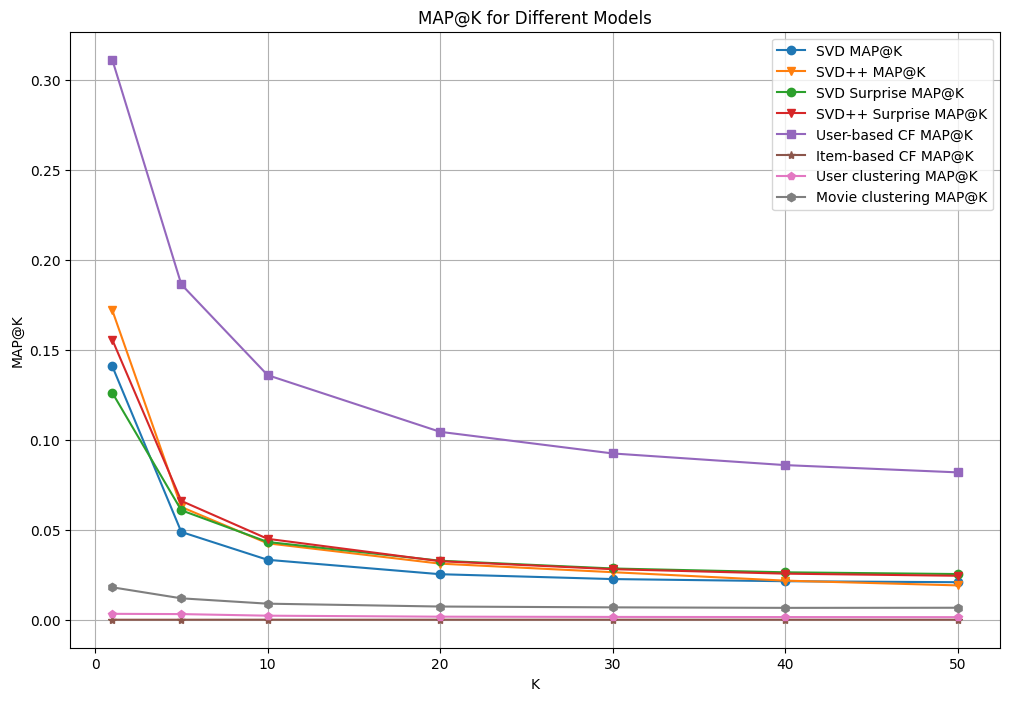

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Графики для MAP@K
plt.plot(df_updated['K'], df_updated['SVD MAP@K'], label='SVD MAP@K', marker='o')
plt.plot(df_updated['K'], df_updated['SVD++ MAP@K'], label='SVD++ MAP@K', marker='v')
plt.plot(df_updated['K'], df_updated['SVD Surprise MAP@K'], label='SVD Surprise MAP@K', marker='o')
plt.plot(df_updated['K'], df_updated['SVD++ Surprise MAP@K'], label='SVD++ Surprise MAP@K', marker='v')
plt.plot(df_updated['K'], df_updated['User-based CF MAP@K'], label='User-based CF MAP@K', marker='s')
plt.plot(df_updated['K'], df_updated['Item-based CF MAP@K'], label='Item-based CF MAP@K', marker='*')
plt.plot(df_updated['K'], df_updated['User clustering MAP@K'], label='User clustering MAP@K', marker='p')
plt.plot(df_updated['K'], df_updated['Movie clustering MAP@K'], label='Movie clustering MAP@K', marker='h')

plt.title('MAP@K for Different Models')
plt.xlabel('K')
plt.ylabel('MAP@K')
plt.legend()
plt.grid(True)
plt.show()

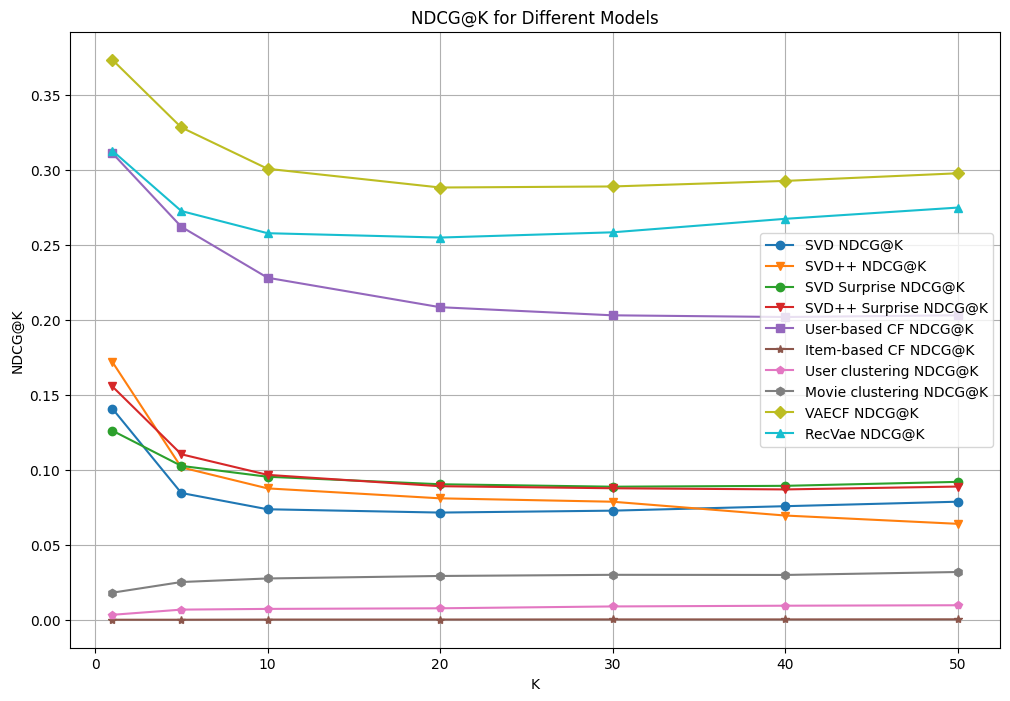

In [ ]:
plt.figure(figsize=(12, 8))

# Графики для NDCG@K
plt.plot(df_updated['K'], df_updated['SVD NDCG@K'], label='SVD NDCG@K', marker='o')
plt.plot(df_updated['K'], df_updated['SVD++ NDCG@K'], label='SVD++ NDCG@K', marker='v')
plt.plot(df_updated['K'], df_updated['SVD Surprise NDCG@K'], label='SVD Surprise NDCG@K', marker='o')
plt.plot(df_updated['K'], df_updated['SVD++ Surprise NDCG@K'], label='SVD++ Surprise NDCG@K', marker='v')
plt.plot(df_updated['K'], df_updated['User-based CF NDCG@K'], label='User-based CF NDCG@K', marker='s')
plt.plot(df_updated['K'], df_updated['Item-based CF NDCG@K'], label='Item-based CF NDCG@K', marker='*')
plt.plot(df_updated['K'], df_updated['User clustering NDCG@K'], label='User clustering NDCG@K', marker='p')
plt.plot(df_updated['K'], df_updated['Movie clustering NDCG@K'], label='Movie clustering NDCG@K', marker='h')
plt.plot(df_updated['K'], df_updated['VAECF NDCG@K'], label='VAECF NDCG@K', marker='D')
plt.plot(df_updated['K'], df_updated['RecVae NDCG@K'], label='RecVae NDCG@K', marker='^')

plt.title('NDCG@K for Different Models')
plt.xlabel('K')
plt.ylabel('NDCG@K')
plt.legend()
plt.grid(True)

plt.show()